In [2]:
##Python 101 librarires
import pandas as pd
import numpy as np
import math
import matplotlib.pyplot as plt
import seaborn as sns
import time

import shap
import lime
from lime.lime_tabular import LimeTabularExplainer

#sklearn
from sklearn.datasets import load_iris, load_diabetes
from sklearn.feature_selection import RFE,mutual_info_regression, SelectKBest
from sklearn.linear_model import LogisticRegression, LinearRegression, LassoCV
from sklearn.model_selection import train_test_split, KFold
from sklearn.ensemble import ExtraTreesRegressor, RandomForestRegressor
from sklearn.metrics import mutual_info_score, r2_score
from sklearn.inspection import partial_dependence,PartialDependenceDisplay
# from sklearn.inspection import plot_partial_dependence

# statsmodels
from statsmodels.stats.outliers_influence import variance_inflation_factor
import statsmodels.api as sm


#Ignore annoying warnings
import warnings
warnings.filterwarnings('ignore')

In [3]:
##loading the datasets

diabetes = load_diabetes()
X_diabetes  = diabetes.data 
y_diabetes = diabetes.target

# Contents




# Motivation 
This report is made to explore a very confusing topic in Data Science which is Feature Importance. We will be exploring various techniques and methodologies to understand feature importance. We will use two famous datasets from the sklearn library illustrate the codes. The report is in two sections:

<b><U> Section 1 - Pre Model Building </u></b>: Understanding <b>feature selection</b> and feature importance before a model is built and used, the math behind it and how to implement it using python. 

<b><U> Section 2 - Post Model Building </u></b>: Understanding <b>feature importance</b> inside a model, the different classes of these methodologies and python examples:

**!! This notebook is created as part of USFCA-MSDS-689 course assignment. Please don't reproduce it in any way.!!**

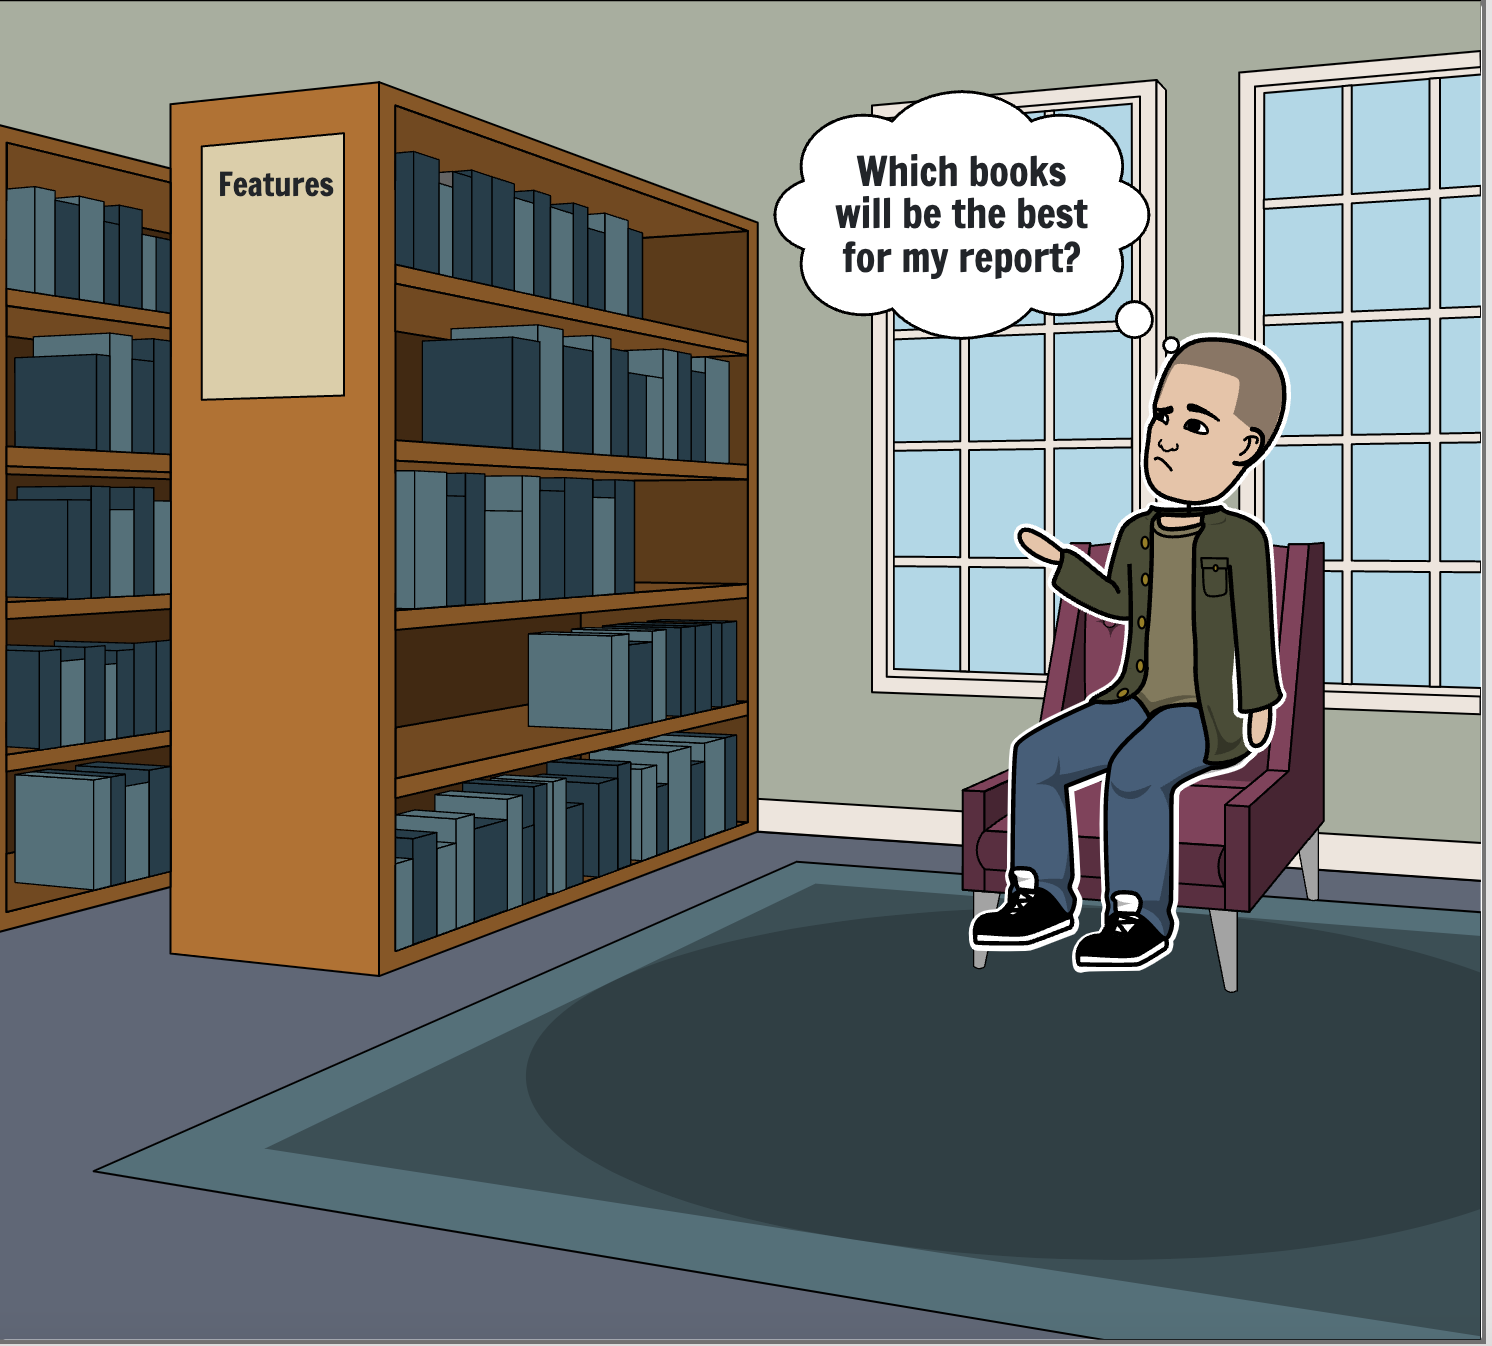

Imagine you have to write a report on a certain topic, you go to the library and end up seeing many books and literature available on the topic,you can't use all of them because there might be overlaps, different ways of expressing a point, there might be some points in a book which is not present in others and many more such scenarios can arrise. Huh!! What do I do?? I have 100 books present related to the topic of my report but I can somehow carry a maximum of 10 books with me, so I need to select wisely so that I can end up getting an A in my report. Let's see how this situation is similar to the topic at hand; essentially the topic is our machine learning model, all the books in the library are the set of available features and the books I can carry are the best features which will give me enough or equivalent knowledge of combining all the books. So how do we decide which books or features to consider?? This is what we term as <b> Feature selection <b/>.


Let's formally define feature selection first- <i>"Feature selection is a process of selecting a subset of relevant features from a larger set of available features in a dataset. It involves identifying and removing features that are irrelevant, redundant, or do not contribute much to the predictive power of a machine learning model."</i> 

There are a lot of different techniques to select the best features, we are going to go over a few of them in the next few sections of this notebook. We are going to first consider techniques which are common to both regression and classification.

#### Technique 1
##### Prior/Domain knowledge

This is the fastest way to select feature. In terms of our report writing case, if our proffesor already mentions two books then we don't need to wrack our brains to find the best combination of books, rather we will simply select the books and walk out happy. So, if we have enough prior or domain knowledge we might know which are our most important features for the model and we can just use them and get our desired results. If it's so simple then why don't we use it?? Because of the following reasons:
- There might be bias that we are introducing unknowingly 
- There might be other features which are important but are being ignored entirely
- It is difficult to gain enough knowledge on a short span of time
- Our intuitions might not match the math

Since this technique is not that effective, what's next ?

#### Technique 2
##### Heat Map and Correlation Matrix

Before jumping into the definition let's relate it to our report writing scenario, if we can glance through the contents of each of the books and measure which books are most similar, how much similar and which books has the highest number of topics then we can eliminate books which has similar topics. Therefore this similarity that we are checking for is the correlation across columns, the range of topics is equivalent to the variance of the feature. If a feature has low or no variance then it is hardly influencing our target and hence we can ignore them. Now let's formally define them:

A correlation matrix is a table that shows the pairwise correlation coefficients between different variables in a dataset. Each cell in the table shows the correlation coefficient between two variables. The diagonal cells are always equal to 1, since a variable is perfectly correlated with itself.

A heatmap, on the other hand, is a visual representation of the correlation matrix. It uses color coding to represent the values in the correlation matrix. Typically, warmer colors (such as red) are used to indicate high positive correlations, cooler colors (such as blue) are used to indicate high negative correlations, and neutral colors (such as white) are used to indicate low or no correlation.

Heatmaps can be useful for quickly identifying patterns in the correlation matrix and identifying which variables are most strongly correlated with each other. They can also help to identify potential multicollinearity issues, where two or more variables are highly correlated with each other, which can cause problems in some machine learning models.

Let's see python implementation of this using our iris data-set(Note:same logic for the other dataset as well)

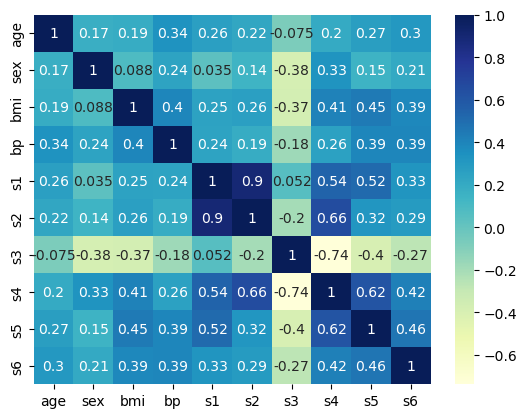

In [4]:
# Create a correlation matrix
diabetes_df = pd.DataFrame(data=diabetes.data, 
                  columns=diabetes.feature_names)
corr_matrix = diabetes_df.corr()

# Create a heatmap of the correlation matrix
sns.heatmap(corr_matrix, annot=True, cmap="YlGnBu")

# Show the plot
plt.show()

If there is correlation among the features we generally use VIF to eliminate those features. VIF stands for Variance Inflation Factor, implementing on the iris dataset and after setting some threshold we can remove and make our model more generalized. Below is the python implementation of VIF

In [5]:
#VIF
feature_names = diabetes.feature_names

vif = pd.DataFrame()
vif["VIF Factor"] = [variance_inflation_factor(X_diabetes, i) for i in range(X_diabetes.shape[1])]
vif["features"] = feature_names

print(vif)

   VIF Factor features
0    1.217307      age
1    1.278071      sex
2    1.509437      bmi
3    1.459428       bp
4   59.202510       s1
5   39.193370       s2
6   15.402156       s3
7    8.890986       s4
8   10.075967       s5
9    1.484623       s6


VIF values more than 10(general threshold considered) indicates multi-collinearity and hence we can drop them, in this case feature 4,5,6 and 8.We can consider 8 and not drop it as it is in the border, so it's totally upto us. 

#### Technique 4
##### Recursive Feature Elimination


Recursive feature elimination (RFE) is a feature selection method that recursively selects a subset of features from a given dataset by training a model and eliminating the least important features at each iteration. 

RFE is a backward selection method, meaning that it starts with all available features and eliminates them one by one. It is a computationally expensive method, as it requires training and evaluating a model multiple times on different subsets of the dataset. However, it can be effective in reducing the number of features in a dataset while still maintaining or improving the performance of the model.

This is similar to implementing a full-model and comparing it with reduced models to find the right number of features and the right features.

In [6]:
model = LogisticRegression()

# Create a RFE selector with 2 features to select
selector = RFE(model, n_features_to_select=2)
               
selector = selector.fit(X_diabetes, y_diabetes)

# Print the selected features
print(selector.support_)

# Print the feature rankings
print(selector.ranking_)               

[False False  True False False False False False  True False]
[5 7 1 3 8 9 2 4 1 6]


<b>!! This is a computationally expensive technique, since our dataset is small, we can use it for demonstration.<b/>

#### Technique 5
##### 5.1 Model Based Techniques - Linear Models

<B>Linear Regression</B>


In [7]:
# Add a column of ones for the intercept term
## We will use the diabetes dataset for this as it is more apt for regression
X_diabetes_ = sm.add_constant(X_diabetes)

# Fit the linear regression model
model = sm.OLS(y_diabetes, X_diabetes_).fit()

model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.518
Model:                            OLS   Adj. R-squared:                  0.507
Method:                 Least Squares   F-statistic:                     46.27
Date:                Sat, 11 Mar 2023   Prob (F-statistic):           3.83e-62
Time:                        16:26:03   Log-Likelihood:                -2386.0
No. Observations:                 442   AIC:                             4794.
Df Residuals:                     431   BIC:                             4839.
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const        152.1335      2.576     59.061      0.000     147.071     157.196
x1           -10.0099     59.749     -0.168      0.867    -127.446     107.426
x2          -239.8156     61.222     -3.917      0.000    -360.147    -119.484
x3           519.8459     66.533      7.813      0.000     389.076     650.616
x4           324.3846     65.422      4.958      0.000     195.799     452.970
x5          -792.1756    416.680     -1.901      0.058   -1611.153      26.802
x6           476.7390    339.030      1.406      0.160    -189.620    1143.098
x7           101.0433    212.531      0.475      0.635    -316.684     518.770
x8           177.0632    161.476      1.097      0.273    -140.315     494.441
x9           751.2737    171.900      4.370      0.000     413.407    1089.140
x10           67.6267     65.984      1.025      0.306     -62.064     197.318
==============================================================================
Omnibus:                        1.506   Durbin-Watson:                   2.029
Prob(Omnibus):                  0.471   Jarque-Bera (JB):                1.404
Skew:                           0.017   Prob(JB):                        0.496
Kurtosis:                       2.726   Cond. No.                         227.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

The p value along with the coefficient values of each feature gives us an estimate as to how strong the features are. We can see that x1,x6, x7 and x8 has p-value more than 0.05 therefore  we can drop as it has the least influence on our prediction.

<B>Lasso Regression</B>

In [8]:
# Let's try using Lasso with cross validation to see if our results match with the above conclusion

cv = KFold(n_splits=2, random_state=13, shuffle=True)

lasso_cv_ =LassoCV(alphas = [1e-3, 1e-2, 1e-1, 1, 10], random_state = 13, cv = cv)
lasso_cv_.fit(X_diabetes, y_diabetes)

coefficients = lasso_cv_.coef_
importance = np.abs(coefficients)

features = diabetes.feature_names


l = np.array(features)[importance >0].shape[0]
l_ = np.array(features)[importance == 0].shape[0]
print('Number of features used in total by the Lasso model = {}'.format(l))
print('Number of features dropped in total by the Lasso model = {}'.format(l_))
print('-------------------------------------------------------------')

print('Final features used = {}'.format(np.array(features)[importance > 0].T))

Number of features used in total by the Lasso model = 7
Number of features dropped in total by the Lasso model = 3
-------------------------------------------------------------
Final features used = ['sex' 'bmi' 'bp' 's1' 's3' 's5' 's6']


Therefore with Lasso we are able to see which are the most influential features to our model, using Linear regression we were dropping 4 but with Lasso we are dropping 3.

##### 5.2 Model Based Techniques - Tree based models

Feature ranking:
1. feature 2 (0.252196)
2. feature 8 (0.229566)
3. feature 3 (0.108556)
4. feature 7 (0.075984)
5. feature 9 (0.073773)
6. feature 6 (0.064183)
7. feature 0 (0.059274)
8. feature 5 (0.051814)
9. feature 4 (0.050250)
10. feature 1 (0.034403)


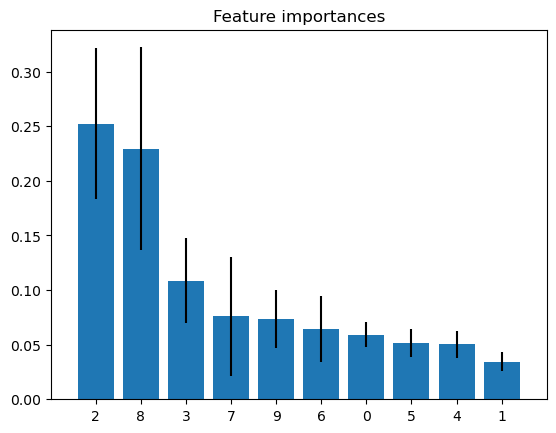

In [9]:
#Using an Extra Tree ensemble to find important features in our dataset, this model can also be used post-model creation to decide which features are most important in the model output
model = ExtraTreesRegressor()
model.fit(X_diabetes, y_diabetes)

importances = model.feature_importances_
std = np.std([tree.feature_importances_ for tree in model.estimators_], axis=0)
indices = np.argsort(importances)[::-1]

print("Feature ranking:")
for f in range(X_diabetes.shape[1]):
    print("%d. feature %d (%f)" % (f + 1, indices[f], importances[indices[f]]))

plt.figure()
plt.title("Feature importances")
plt.bar(range(X_diabetes.shape[1]), importances[indices], yerr=std[indices], align="center")
plt.xticks(range(X_diabetes.shape[1]), indices)
plt.xlim([-1, X_diabetes.shape[1]])
plt.show()

#### Technique 6
##### Mutual Information Regression

MIR is a technique that quantifies the mutual information between each feature and the target variable in a regression setting. It is a measure of how much information about the target variable is contained in a feature. Features with high mutual information with the target variable are considered to be important and are selected for the model.

In [10]:
# Calculate mutual information for each feature
mi = mutual_info_regression(X_diabetes, y_diabetes)

# Create a dataframe to store the mutual information scores for each feature
mi_df = pd.DataFrame({'feature': diabetes.feature_names, 'MI score': mi})

# Sort the dataframe by MI score in descending order
mi_df = mi_df.sort_values(by=['MI score'], ascending=False)

# Print the top 5 features with the highest MI score
print(mi_df.head(5))

  feature  MI score
2     bmi  0.175349
8      s5  0.146735
7      s4  0.106153
9      s6  0.105727
4      s1  0.067753


In [11]:
#SelectKBest is a feature selection method which is used to select the K best features based on their mutual information with the target variable
selector = SelectKBest(score_func=mutual_info_regression, k=5)
X_new = selector.fit_transform(X_diabetes, y_diabetes)

print(selector.get_support(indices=True))

[2 3 7 8 9]


#### Technique 7
##### mRMR- minimum Redundancy Maximum Relevance

mRMR, is a technique that selects features based on their relevance to the target variable and their redundancy with each other. It aims to select features that are highly relevant to the target variable, while also minimizing redundancy between the selected features.

The other way of looking at it is - mRMR, or minimum redundancy maximum relevance, is a feature selection algorithm that aims to select a subset of features that are both highly relevant to the target variable and minimally redundant with each other.

The algorithm works by first computing the relevance of each feature with respect to the target variable, typically using a measure such as mutual information or correlation. It then computes the redundancy between each pair of features, typically using a measure such as Pearson correlation or mutual information.

The mRMR algorithm then proceeds in a forward selection manner, iteratively adding features to the subset while ensuring that the subset has high relevance to the target variable and low redundancy between features. At each step, the algorithm selects the feature that has the highest relevance to the target variable and the lowest redundancy with respect to the features already in the subset.

The math behind mRMR involves computing the mutual information between each feature and the target variable, as well as between each pair of features. Mutual information is a measure of the dependence between two random variables, and is given by:

$$I(X; Y) = ∑∑ p(x, y) log(p(x, y) / p(x) p(y))$$

where X and Y are the random variables, p(x, y) is the joint probability distribution of X and Y, and p(x) and p(y) are the marginal probability distributions of X and Y, respectively.

The algorithm also computes a measure of redundancy between each pair of features, typically using a formula such as:

$$R(Xi, Xj) = I(Xi; Xj) / (H(Xi) + H(Xj))$$

where Xi and Xj are the two features being compared, I(Xi; Xj) is the mutual information between Xi and Xj, and H(Xi) and H(Xj) are the entropies of Xi and Xj, respectively. The redundancy measure is then subtracted from the relevance measure to obtain a final score for each feature, which is used to rank the features and select the subset.

In summary, MIR quantifies the relationship between each feature and the target variable, while mRMR selects a subset of features that are both highly relevant to the target variable and minimally redundant with each other.


In [12]:
def mrmr(X, y, k):
    n_features = X.shape[1]
    selected_features = []
    remaining_features = list(range(n_features))

    # First feature selected is the one with maximum mutual information with the target
    mi = np.zeros(n_features)
    for j in range(n_features):
        mi[j] = mutual_info_score(X[:, j], y)
    best_feature = np.argmax(mi)
    selected_features.append(best_feature)
    remaining_features.remove(best_feature)

    # Select remaining features using mRMR criterion
    for i in range(k-1):
        max_mrmr = -np.inf
        best_feature = -1
        for j in remaining_features:
            relevancy = mutual_info_regression(X[:, j].reshape(-1, 1), y.reshape(-1, 1))[0]
            redundancy = np.sum([mutual_info_score(X[:, j], X[:, s]) for s in selected_features])
            mrmr_j = relevancy - redundancy
            if mrmr_j > max_mrmr:
                max_mrmr = mrmr_j
                best_feature = j
        selected_features.append(best_feature)
        remaining_features.remove(best_feature)

    return selected_features

selected_features = mrmr(X_diabetes, y_diabetes, 5)

print("Selected features:", selected_features)

Selected features: [5, 1, 7, 9, 0]


Since we have explored quite a few techniques for feature selection, let's explore feature importance techniques. Using the above techniques we were able to select the best features out of all the features to have the best generalized model. 

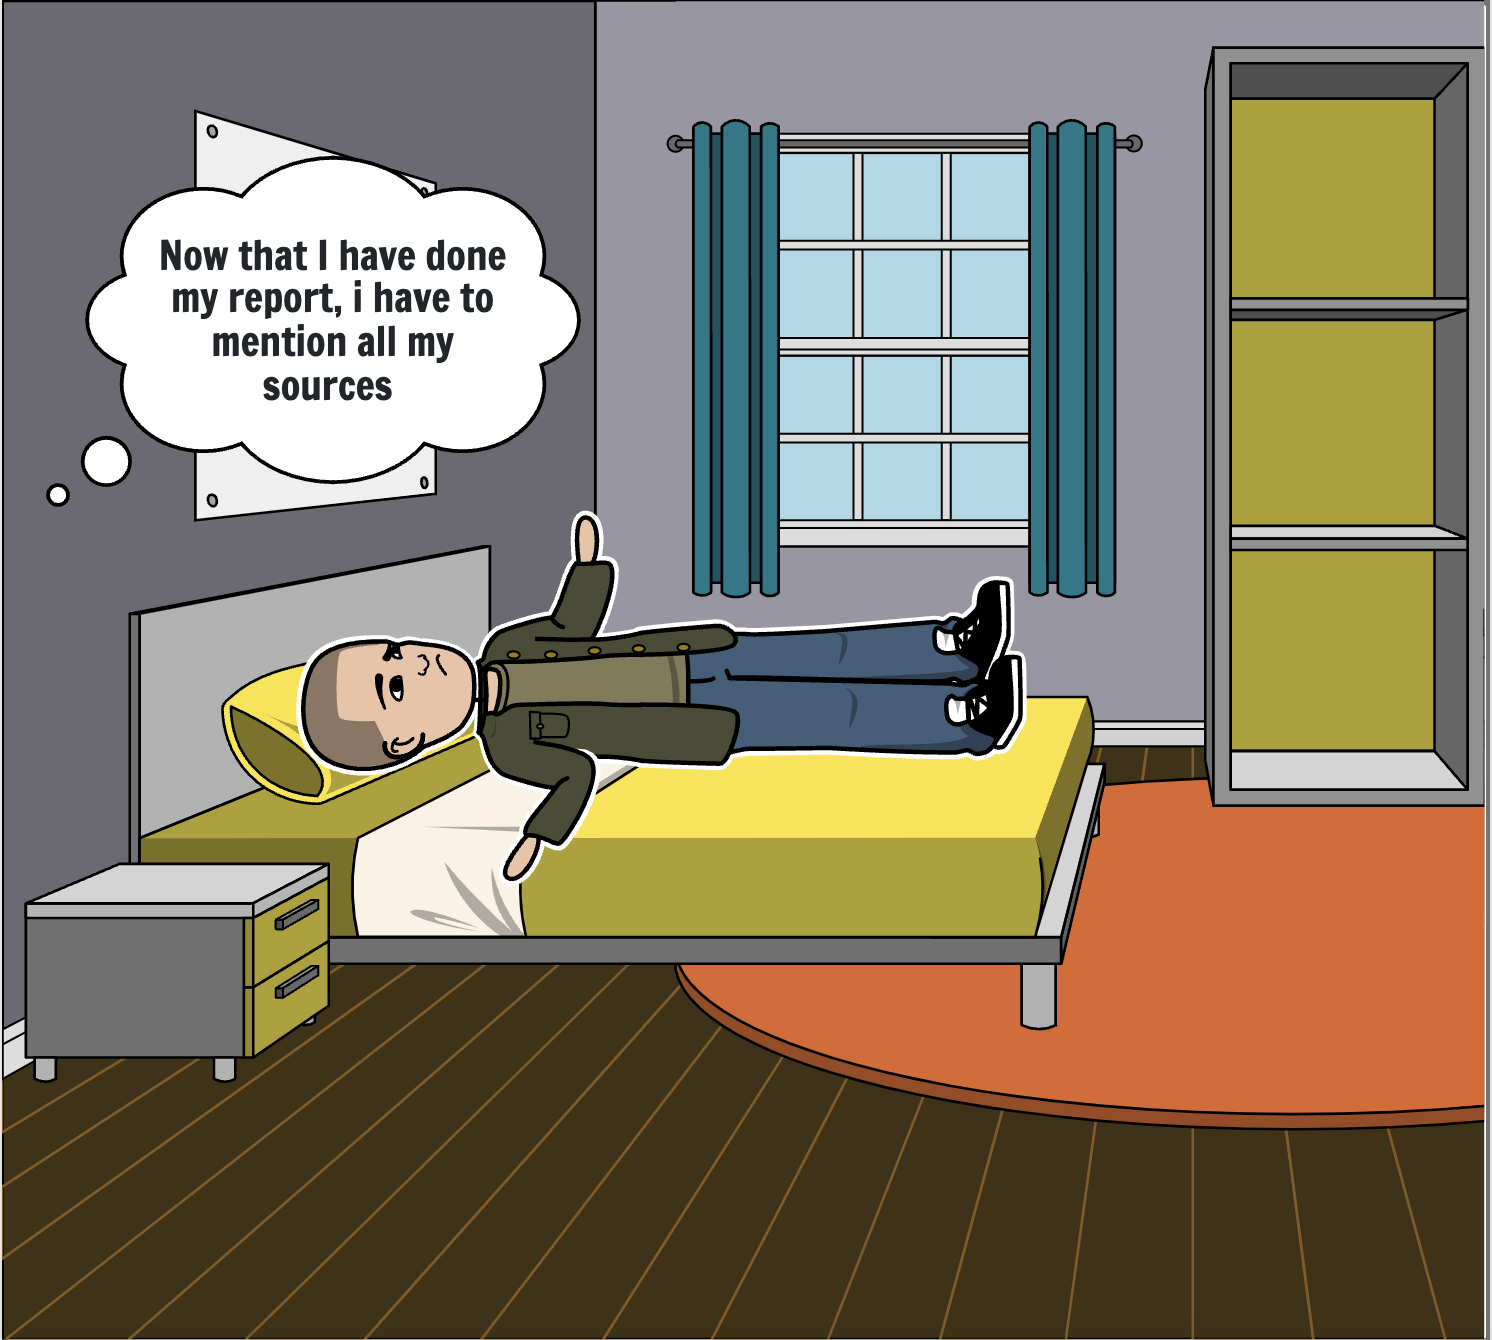

Now that we have found our books, created our report, I want to know which books influenced us the most and how it shaped our report.This is what we term as <b> Feature Importance <b/>.


Let's formally define feature selection first- <i>"Feature importance is a technique used to determine the most important features or variables in a dataset that are contributing the most towards predicting the target variable. In other words, it is a way of understanding which features have the most impact on the model's output."</i> 

Let's divide the techniques into the following types:
- Global Importance: It tells us on average, what features are important across the entire dataset
- Local Importance: It tells us the importance of each feature for a specific prediction
    
On further division we can get the following two methodologies:
- Model Specific: These methods doesn't generalize to all model types
- Model Agnostic: These methods apply to all model types

We have seen a few of the techniques which we can apply apply for feature importance as well for example the coefficients of a linear regression model tells us about the relationship, similarly Extra Trees is a tree based explainers technique to rank features. 

#### Technique 1
##### Permutation Importance

Permutation importance is a method for measuring the importance of each feature in a machine learning model. It works by randomly permuting the values of a feature in the test set and measuring how much the performance of the model drops as a result. The idea is that if a feature is important, then permuting its values should cause the model's performance to decrease significantly, since the model relies heavily on that feature for making predictions.

More specifically, the permutation importance score for a feature is computed by evaluating the model's performance on a validation set before and after randomly permuting the feature's values in the validation set. The feature importance score is then calculated as the difference between the two performance metrics. A higher score indicates that the feature is more important, since permuting its values has a greater impact on the model's performance.

Permutation importance is a model-agnostic method, meaning that it can be used with any type of model, including decision trees, random forests, linear models, and neural networks. It is often used as an alternative or complement to other feature selection methods, such as recursive feature elimination or feature importance from a model's coefficients.

In [13]:
X, y = load_diabetes(return_X_y=True)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

rf = RandomForestRegressor(random_state=42)
rf.fit(X_train, y_train)

RandomForestRegressor(random_state=42)

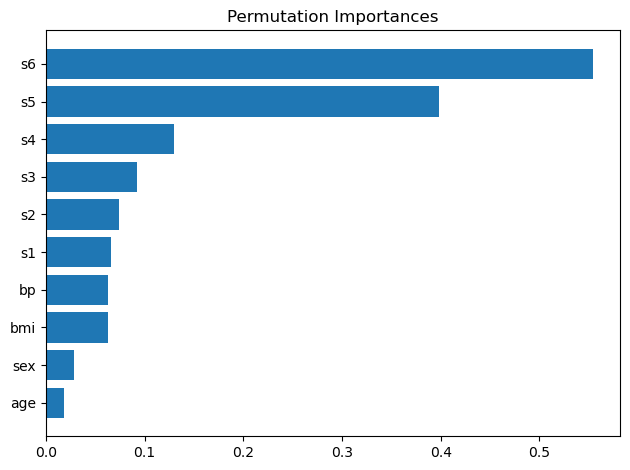

In [14]:
from sklearn.inspection import permutation_importance

result = permutation_importance(rf, X_train, y_train, n_repeats=10,
                                random_state=42, n_jobs=2)
sorted_idx = result.importances_mean.argsort()

fig, ax = plt.subplots()
ax.barh(diabetes.feature_names, result.importances[sorted_idx].mean(axis=1).T)
ax.set_title("Permutation Importances")
fig.tight_layout()
plt.show()

#### Technique 3
##### SHAPLEY Values

Shapley values are a concept from cooperative game theory that assigns a value to each feature in a prediction, indicating how much that feature contributes to the overall prediction. In the context of machine learning models, Shapley values can be used to understand the importance of each feature in making a particular prediction.

The basic idea of Shapley values is to compute the marginal contribution of each feature by comparing the prediction for a given data point with and without the feature included. The contribution of a feature is then computed as the difference between the prediction with the feature included and the prediction with the feature excluded, weighted by the number of possible ways the feature can be included in all possible feature subsets. This gives us a measure of the importance of each feature in the prediction.

In the context of machine learning, Shapley values can be used to explain the output of a model for a specific data point. For example, given an image classification model, we can use Shapley values to determine which pixels of the image contributed the most towards the predicted class.

To calculate the Shapley values, we can use the Shapley value formula:

$$\phi_i(v) = \sum_{S \subseteq N \setminus {i}} \frac{|S|!(|N|-|S|-1)!}{|N|!} (v(S \cup {i}) - v(S))$$

Where $\phi_i(v)$ represents the Shapley value of feature $i$ for a given data point with feature values $v$, $N$ is the set of all features, $S$ is a subset of features not including feature $i$, $|S|$ represents the size of subset $S$, and $|N|$ represents the total number of features. The term $(v(S \cup {i}) - v(S))$ represents the marginal contribution of feature $i$ to the prediction when included in subset $S \cup {i}$ compared to subset $S$.

To compute the Shapley values for a given data point, we need to calculate the marginal contribution for each feature over all possible feature subsets. This can be a computationally intensive process, especially for large datasets and complex models. However, several algorithms have been developed to efficiently estimate the Shapley values, such as KernelSHAP and TreeSHAP, which are specifically designed for tree-based models like Random Forest.

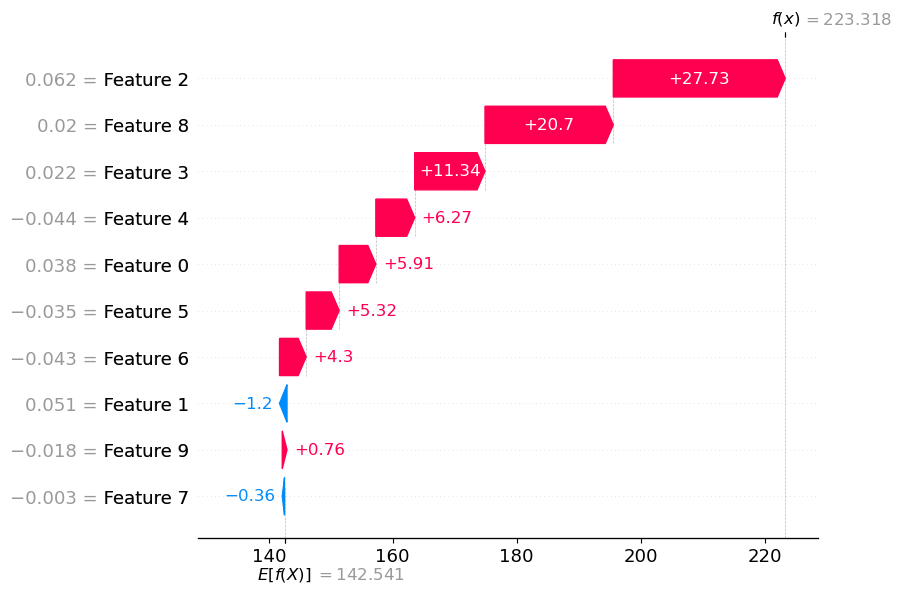

In [15]:
# Initialize the SHAP explainer with the trained model and data
explainer = shap.Explainer(rf, X)

# Calculate the SHAP values for a single instance of the data
shap_values = explainer(X[0:1])

# Plot the SHAP values for the prediction
shap.plots.waterfall(shap_values[0])

#### Technique 4
##### Local Interpretable Model Agnostic Explanations

LIME (Local Interpretable Model-agnostic Explanations) is an algorithm that explains the predictions of any black-box model by learning a local interpretable model around the prediction. The idea behind LIME is to approximate the original complex model locally, by generating local explanations based on the locally linear model. The steps involved in LIME are as follows:

Sample data points around the point to be explained: In this step, LIME samples data points around the point to be explained. This sampling can be done in different ways, such as uniform sampling or by using a distance metric like Euclidean distance.

Generate local linear model: For each sampled data point, a linear model is generated using LASSO regularization. LASSO regularization is used to enforce sparsity in the feature weights, which means that the features that are not important for the prediction will have a weight of zero.

Weight the local models: The weight of each linear model is determined based on the similarity of the sampled data point to the point to be explained. The similarity can be calculated using a distance metric like cosine similarity.

Compute feature importance: The feature importance is computed by aggregating the weights of each feature across all the local models. The features with higher weights are considered more important for the prediction.

Generate the explanation: The final explanation is generated by presenting the top features with their respective importance values.

LIME is a popular algorithm for generating local explanations, especially for image and text data. It provides a model-agnostic way of explaining the predictions of any black-box model, making it widely applicable.

In [16]:
# Initialize the explainer object
explainer = LimeTabularExplainer(
    X_train,
    feature_names=diabetes.feature_names,
    class_names=["target"],
    verbose=True,
    mode="regression",
    discretize_continuous=True,
    sample_around_instance=True,
)

# Select an instance for explanation
instance = X_test[0]

# Generate an explanation
exp = explainer.explain_instance(
    instance,
    rf.predict,
    num_features=5,
    top_labels=1,
    num_samples=1000,
)

# Print the explanation
exp.show_in_notebook(show_table=True)


Intercept 158.25908866667817
Prediction_local [159.12300842]
Right: 144.0


There are a few more techniques that are available in the market but these are the most used methodologies which are trusted by a majority of people in this field. For more in-depth concepts and other techniques please refer to this book(https://christophm.github.io/interpretable-ml-book/). 

SHAP and LIME are very useful in deep-learning and getting insights from neural networks. For classical machine learning, permutation importance, model based techniques does the job 90% of the time.